In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (7,7)
import numpy as np

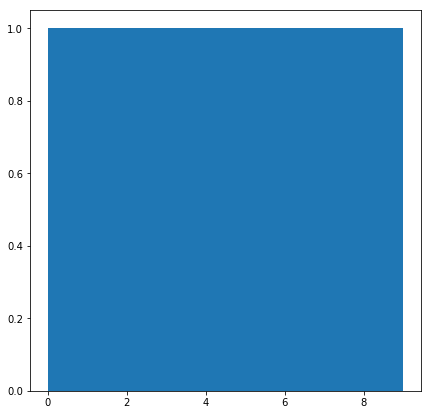

In [4]:
plt.hist(np.arange(10))
plt.show()

In [5]:
from __future__ import print_function
import time, os, glob
import ROOT
from array import array

Welcome to JupyROOT 6.20/02


In [6]:
def get_cp_err(num, den, num_err=None, den_err=None):

        # Clopper-Pearson errors
        # tail = (1 - cl) / 2
        # 2sigma (95% CL): tail = (1 - 0.95) / 2 = 0.025
        # 1sigma (68% CL): tail = (1 - 0.68) / 2 = 0.16
        tail = 0.16
        
        if num == 0. or den == 0: return 1.
        
        if num_err is None:
            num_err = np.sqrt(num)
        if den_err is None:
            den_err = np.sqrt(den)

        n_num = pow(num/num_err, 2.)
        n_den = pow(den/den_err, 2.)

        # nom
        n_rat = n_num / n_den

        # lower limit
        q_low = ROOT.Math.fdistribution_quantile_c(1-tail, n_num*2, (n_den+1)*2)
        r_low = q_low * n_num / (n_den + 1)

        # upper limit
        q_high = ROOT.Math.fdistribution_quantile_c(tail, (n_num+1)*2, n_den*2)
        r_high = q_high * (n_num + 1) / n_den

        # lower, upper errors
        err_lo, err_hi = n_rat - r_low, r_high - n_rat

        #return err_lo, err_hi
        #err_ = np.sqrt(np.mean(np.array([err_lo, err_hi])**2))
        err_ = err_lo if num/den > 1. else err_hi
        return err_

In [7]:
samples = ['Run2017', 'DYToEE']
#samples = ['Run2017']
ma, wgt = {}, {}

for s in samples:
    in_files = glob.glob('Templates/%s*_ma1.txt'%s)
    print(in_files)
    
    ma[s], wgt[s] = [], []
    for in_file in in_files:
        f = open(in_file, "r")
        for l in f:
            ma_, wgt_ = l.replace('\n','').split(':')
            ma[s].append(float(ma_))
            wgt[s].append(float(wgt_))

    ma[s] = np.array(ma[s])
    wgt[s] = np.array(wgt[s])
    wgt[s] = wgt[s][ma[s] > -0.2]
    ma[s] = ma[s][ma[s] > -0.2]
    assert len(ma[s] == wgt[s])
    print(len(ma[s]), len(wgt[s]))
    print(ma[s][:5])
    print(wgt[s][:5])

['Templates/Run2017B_ma1.txt', 'Templates/Run2017E_ma1.txt', 'Templates/Run2017C_ma1.txt', 'Templates/Run2017D_ma1.txt']
1960031 1960031
[0.069651 0.039235 0.082894 0.139563 0.51743 ]
[1. 1. 1. 1. 1.]
['Templates/DYToEE_ma1.txt']
2084409 2084409
[-0.104737 -0.005871  0.348417  0.206033  0.112075]
[0.969015 0.931203 0.760811 0.830483 0.930548]


[-0.2    0.     0.025  0.05   0.075  0.1    0.125  0.15   0.175  0.2
  0.225  0.25   0.275  0.3    0.325  0.35   0.375  0.4    0.425  0.45
  0.475  0.5    0.525  0.55   0.575  0.6    0.625  0.65   0.675  0.7
  0.725  0.75   0.775  0.8    0.825  0.85   0.875  0.9    0.925  0.95
  0.975  1.     1.025  1.05   1.075  1.1    1.125  1.15   1.175  1.2
  1.6  ]
[-0.1     0.0125  0.0375  0.0625  0.0875  0.1125  0.1375  0.1625  0.1875
  0.2125  0.2375  0.2625  0.2875  0.3125  0.3375  0.3625  0.3875  0.4125
  0.4375  0.4625  0.4875  0.5125  0.5375  0.5625  0.5875  0.6125  0.6375
  0.6625  0.6875  0.7125  0.7375  0.7625  0.7875  0.8125  0.8375  0.8625
  0.8875  0.9125  0.9375  0.9625  0.9875  1.0125  1.0375  1.0625  1.0875
  1.1125  1.1375  1.1625  1.1875  1.2125]


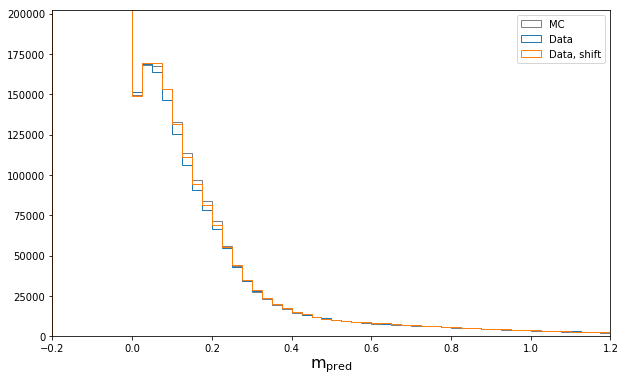

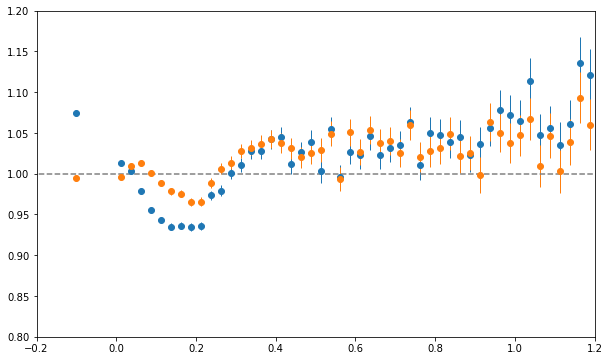

In [20]:
plt.rcParams["figure.figsize"] = (10,6)

#bins_ = 120
dM = 25
bins_ = np.concatenate([[-0.2], np.arange(0,1200+dM,dM)/1000., [1.6]])
#bins_ = np.concatenate([np.arange(-200,0,dM)/1000., np.arange(0,1200+dM,dM)/1000., [1.6]])
bin_ctrs = bins_[:-1].copy()
bin_ctrs[0] = bin_ctrs[0]+0.1
#bin_ctrs[0] = bin_ctrs[0]+(dM/2000.)
bin_ctrs[1:] = bin_ctrs[1:]+(dM/2000.)
#xlims = [-0., 0.2]
xlims = [-0.2, 1.2]
print(bins_)
print(bin_ctrs)

def smear(ma, scale, offset, sigma, sigma_frac=None):
    '''if sigma_frac is None:
        gauss = np.random.normal(mu, sigma, size=len(ma))
        ma_smeared = [m*g for m, g in zip(ma, gauss)]
    else:'''
    if sigma_frac is None:
        ma_smeared = [np.random.normal((scale*m)+offset, sigma) for m in ma]
    else:
        ma_smeared = [np.random.normal((scale*m)+offset, sigma_frac*m) for m in ma]
    return ma_smeared
    
def plot_datavmc(ma, wgt, scale, offset, sigma, make_plot=True):

    mcwgts = wgt['DYToEE']*len(ma['Run2017'][ma['Run2017']>-0.2])/sum(wgt['DYToEE'][wgt['DYToEE']>-0.2])
    #ma_shift = scale*ma['Run2017'] + offset
    ma_shift = smear(ma['Run2017'], scale, offset, sigma, sigma_frac=None)
    
    if make_plot:
        fig = plt.figure()
    hmc, edges, _ = plt.hist(ma['DYToEE'], bins=bins_, histtype='step', label='MC', weights=mcwgts, color='grey')
    hdata, edges, _ = plt.hist(ma['Run2017'], bins=bins_, histtype='step', label='Data', color='C0')
    hdata2, edges, _ = plt.hist(ma_shift, bins=bins_, histtype='step', label='Data, shift', color='C1')
    if not make_plot:
        plt.close()
    
    if make_plot:
        plt.xlim(xlims)
        plt.ylim(0., np.sort(hdata)[-2]*1.2)
        plt.xlabel(r'$\mathrm{m_{pred}}$', size=16)
        plt.legend(loc='upper right')
        plt.show()

        #'''
        fig = plt.figure()
        plt.plot(np.concatenate([[-0.4],bin_ctrs]), np.ones(len(bin_ctrs)+1), color='grey', linestyle='--')
        plt.errorbar(bin_ctrs, hdata/hmc, [get_cp_err(d,mc) for d,mc in zip(hdata, hmc)], marker='o', elinewidth=1., drawstyle='steps-mid', linewidth=0.)
        plt.errorbar(bin_ctrs, hdata2/hmc, [get_cp_err(d,mc) for d,mc in zip(hdata2, hmc)], marker='o', elinewidth=1., drawstyle='steps-mid', linewidth=0.)
        plt.ylim(1.-.2, 1.+.2)
        plt.xlim(xlims)
        plt.show()
        #'''

    return edges, hmc, hdata, hdata2

scale=0.971
offset=6.e-3
sigma=1.e-2
edges, hmc, hdata, hdata2 = plot_datavmc(ma, wgt, scale, offset, sigma)

In [9]:
def get_KL(data, mc):
    data = data/data.sum()
    mc = mc/mc.sum()
    kl = data*np.log(data/mc)
    return kl.sum()

get_KL(hdata2, hmc)

0.00039931238381589473

offsets: [0.005 0.006 0.007]
scales: [0.962 0.963 0.964 0.965 0.966 0.967 0.968 0.969 0.97  0.971]
sigmas: [0.009 0.01  0.011 0.012]
0 / 120
10 / 120
20 / 120
30 / 120
40 / 120
50 / 120
60 / 120
70 / 120
80 / 120
90 / 120
100 / 120
110 / 120
scale_best: 0.971
offset_best: 0.006
sigma_best: 0.01
kl_best: 0.00025112348181495367
kl_nom: 0.002631947505124307


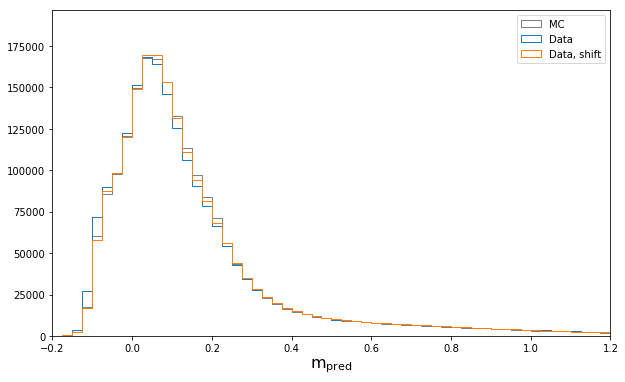

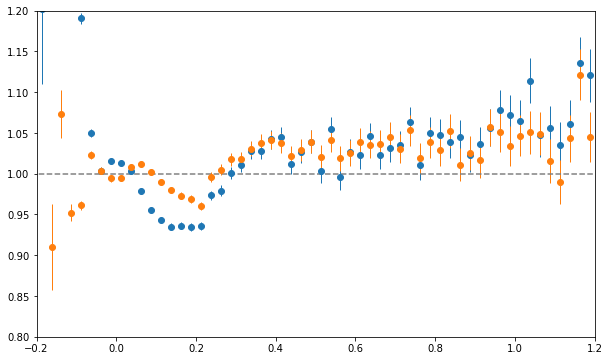

In [10]:
steps = np.arange(1,39)*1.e-3
offsets = steps[4:7]
print('offsets:',offsets)
scales = np.concatenate([1.-np.flip(steps), 1.+steps])
scales = scales[:10]
print('scales:',scales)
sigmas = steps[8:12]
print('sigmas:',sigmas)

scale_best, offset_best, sigma_best = None, None, None
kl_best = 1.
n_iters = len(scales)*len(offsets)*len(sigmas)
it = 0
for scale in scales:
    for offset in offsets:
        for sigma in sigmas:
            if it%10 == 0: print('%d / %d'%(it, n_iters))
            it += 1
            #continue
            edges, hmc, hdata, hdata2 = plot_datavmc(ma, wgt, scale, offset, sigma, make_plot=False)
            kl = get_KL(hdata2, hmc)
            kl_nom = get_KL(hdata, hmc)
            if kl < kl_best:
                kl_best = kl
                scale_best = scale
                offset_best = offset
                sigma_best = sigma

print('scale_best:',scale_best)
print('offset_best:',offset_best)
print('sigma_best:',sigma_best)
print('kl_best:',kl_best)
print('kl_nom:',kl_nom)
edges, hmc, hdata, hdata2 = plot_datavmc(ma, wgt, scale_best, offset_best, sigma_best, make_plot=True)

In [9]:
offsets: [0.005 0.006 0.007]
scales: [0.962 0.963 0.964 0.965 0.966 0.967 0.968 0.969 0.97  0.971]
sigmas: [0.009 0.01  0.011 0.012]
0 / 120
10 / 120
20 / 120
30 / 120
40 / 120
50 / 120
60 / 120
70 / 120
80 / 120
90 / 120
100 / 120
110 / 120
scale_best: 0.971
offset_best: 0.006
sigma_best: 0.01
kl_best: 0.00025112348181495367

offsets: [0.005 0.006 0.007]
scales: [0.971 0.972 0.973 0.974 0.975]
sigmas: [0.009 0.01  0.011 0.012 0.013]
0 / 75
10 / 75
20 / 75
30 / 75
40 / 75
50 / 75
60 / 75
70 / 75
scale_best: 0.971
offset_best: 0.006
sigma_best: 0.01
kl_best: 0.0002512498369564059
    
offsets: [0.004 0.005 0.006]
scales: [0.973 0.974 0.975]
sigmas: [0.009 0.01  0.011 0.012 0.013 0.014]
0 / 54
10 / 54
20 / 54
30 / 54
40 / 54
50 / 54
scale_best: 0.973
offset_best: 0.006
sigma_best: 0.01

offsets: [0.004 0.005 0.006]
scales: [0.971 0.972 0.973 0.974 0.975]
sigmas: [0.006 0.007 0.008 0.009]
0 / 60
10 / 60
20 / 60
30 / 60
40 / 60
50 / 60
scale_best: 0.974
offset_best: 0.005
sigma_best: 0.009000000000000001
kl_best: 0.00026389843355962086
    
offsets: [0.004 0.005 0.006]
scales: [0.969 0.97  0.971 0.972 0.973 0.974 0.975 0.976 0.977 0.978 0.979]
sigmas: [0.005 0.006 0.007]
0 / 99
10 / 99
20 / 99
30 / 99
40 / 99
50 / 99
60 / 99
70 / 99
80 / 99
90 / 99
scale_best: 0.973
offset_best: 0.005
sigma_best: 0.007

offsets: [0.004 0.005 0.006]
scales: [0.979 0.98  0.981 0.982 0.983 0.984 0.985]
sigmas: [0.004 0.005 0.006]
0 / 63
10 / 63
20 / 63
30 / 63
40 / 63
50 / 63
60 / 63
scale_best: 0.979
offset_best: 0.005
sigma_best: 0.006
kl_best: 0.0003194335219820571

offsets: [0.004 0.005 0.006]
scales: [0.985 0.986 0.987 0.988 0.989 0.99 ]
sigmas: [0.003 0.004 0.005]
0 / 54
10 / 54
20 / 54
30 / 54
40 / 54
50 / 54
scale_best: 0.985
offset_best: 0.005
sigma_best: 0.005
kl_best: 0.00040047815373272404
    
offsets: [0.004 0.005 0.006]
scales: [0.99  0.991 0.992 0.993]
sigmas: [0.002 0.003 0.004]
0 / 36
10 / 36
20 / 36
30 / 36
scale_best: 0.99
offset_best: 0.005
sigma_best: 0.004
    
offsets: [0.004 0.005 0.006 0.007]
scales: [0.993 0.994 0.995]
sigmas: [0.001 0.002 0.003]
0 / 36
10 / 36
20 / 36
30 / 36
scale_best: 0.993
offset_best: 0.005
sigma_best: 0.003
kl_best: 0.0005540648304202336

offsets: [0.003 0.004 0.005]
scales: [0.995 0.996 0.997 0.998]
sigmas: [0.001 0.002 0.003]
0 / 36
10 / 36
20 / 36
30 / 36
scale_best: 0.995
offset_best: 0.005
sigma_best: 0.002
kl_best: 0.0006079194886292947

offsets: [0.001 0.002 0.003]
scales: [0.997 0.998 0.999 1.001 1.002 1.003]
sigmas: [0.001 0.002 0.003]
0 / 54
10 / 54
20 / 54
30 / 54
40 / 54
50 / 54
scale_best: 0.997
offset_best: 0.003
sigma_best: 0.001

SyntaxError: invalid syntax (<ipython-input-9-fcc6051b19d7>, line 1)

In [ ]:
#goftest_2 = ROOT.Math.GoFTest(len(ma['DYToEE']), ma['DYToEE'], len(ma['Run2017']), ma['Run2017'])

In [ ]:
'''print(goftest_2.AndersonDarling2SamplesTest("t"))
print(goftest_2.AndersonDarling2SamplesTest())
#goftest_2.KolmogorovSmirnov2SamplesTest()
print(goftest_2.KolmogorovSmirnov2SamplesTest("t"))
'''